# 第十章transformer模型

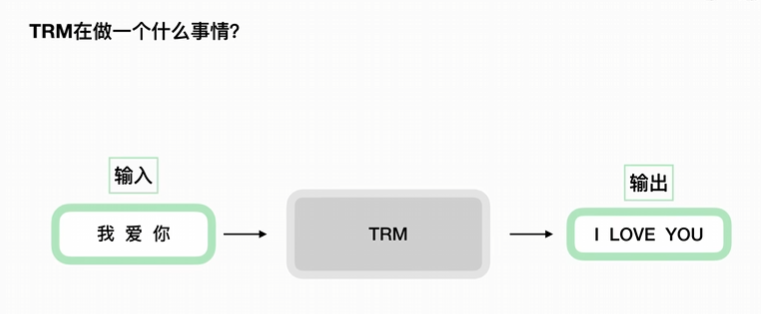

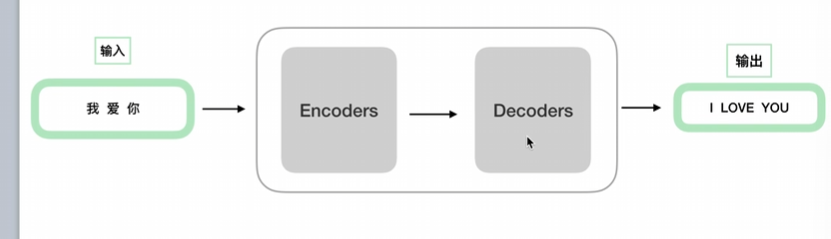

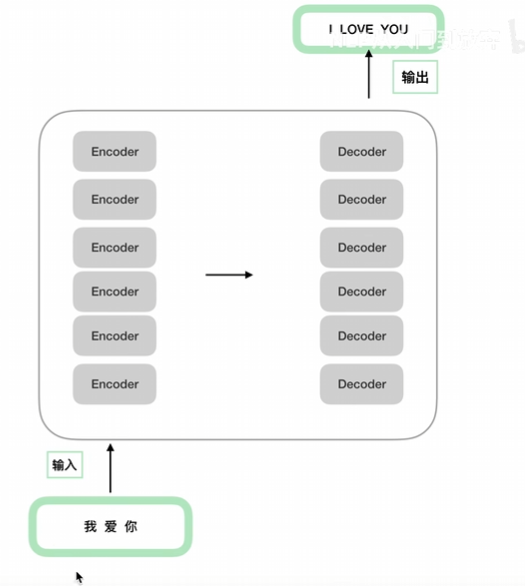

这些encoder是相同的，但是每个参数是不一样的
decoder也是这样，参数不同结构相同
encoder和decoder是不同的

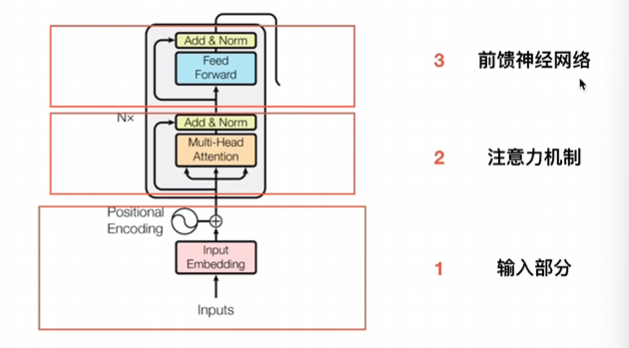

点乘
数越大，相似度越高
qk点乘后于v相乘
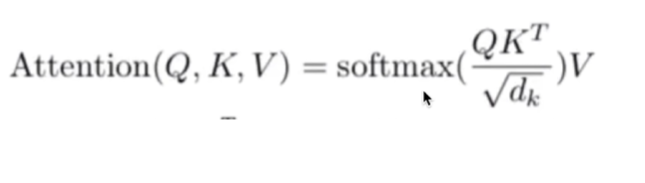

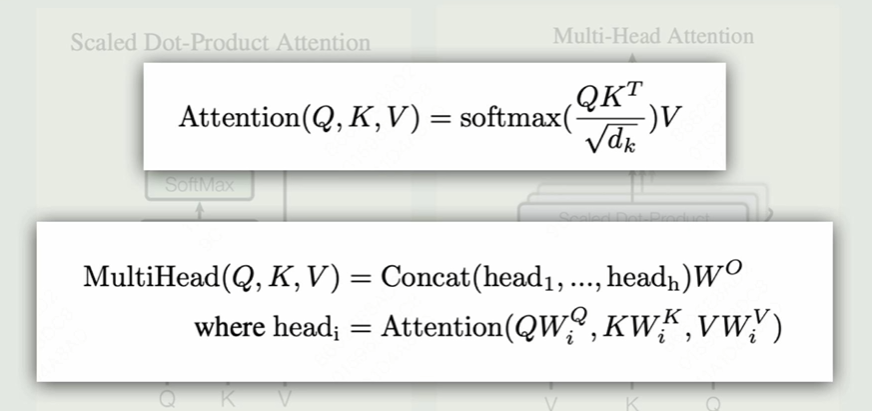

## 代码部分

多头注意力机制

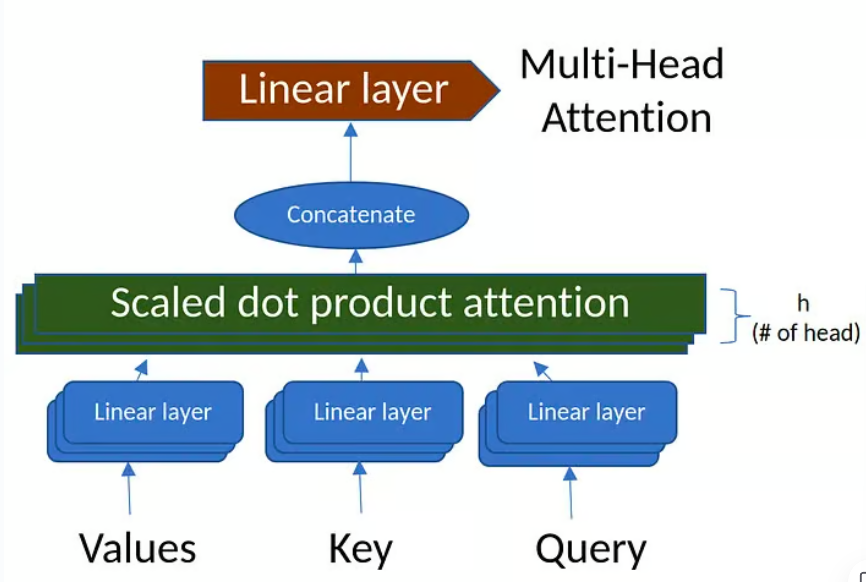

多头注意力机制：将输入分割成多个头，每个头独立计算注意力，最后将结果合并。

缩放点积注意力：计算查询和键的点积，缩放后使用 softmax 计算注意力权重，最后对值进行加权求和。

掩码：用于屏蔽无效位置（如填充部分）。

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,num_heads):
        super(MultiHeadAttention,self).__init__()
        assert d_model % num_heads==0,"d_model必须能够被num_heads整除"

        self.d_model=d_model#模型维度 eg512
        self.num_heads=num_heads#注意力头数eg8
        self.d_k=d_modle//num_heads #每个头的维度 eg 64

        #定义线性变换层，无需偏置
        self.W_q=nn.Linear(d_model,d_model)#查询变换，为什么是这两个参数？
        self.W_k=nn.Linear(d_model,d_model)#键变换
        self.W_v=nn.Linear(d_model,d_model)#值变换
        self.W_o=nn.Linear(d_model,d_model)#输出变换

    def scaled_dot_product_attention(self,Q,K,V,mask=None):
        """
        计算缩放点积注意力，就是那个qkv公式
        输入形状：
            Q: (batch_size, num_heads, seq_length, d_k)
            K, V: 同Q
        输出形状： (batch_size, num_heads, seq_length, d_k)
        """
        attn_scores=torch.matmul(Q,K.transpose(-2,-1))/math.sqrt(self.d_k)#为什么这样要这样转置？

        if mask is not None:
            attn_scores=attn_scores.mask_fill(mask==0,-1e9)#这里干嘛mask_fill操作？

        attn_probs=torch.softmax(attn_scores,dim=-1)
        output=torch.matmul(attn_probs,v)#对值向量进行加权求和

    def split_head(self,x):
        """
        将输入张量分割为多个头
        输入形状: (batch_size, seq_length, d_model)
        输出形状: (batch_size, num_heads, seq_length, d_k)
        """
        batch_size,seq_length,d_model=x.size()#这个是怎么进行对应赋值的
        return x.view(batch_size,seq_length,self.num_heads,self.d_k).transpose(1,2)
        #依旧这个问题，怎么transpose过来的
    #输出形状为 `(batch_size, num_heads, seq_length, d_k)`。

    def combine_heads(self,x):
        """
        将多个头的输出合并回原始形状
        输入形状: (batch_size, num_heads, seq_length, d_k)
        输出形状: (batch_size, seq_length, d_model)
        """
        batch_size, _, seq_length, d_k = x.size()#为啥空一个下划线
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)#这里这些操作干嘛的


    def forward(self,Q,K,V,mask=None):
         """
        前向传播
        输入形状: Q/K/V: (batch_size, seq_length, d_model)
        输出形状: (batch_size, seq_length, d_model)
        """
        Q=self.split_heads(self.W_q(Q))#(batch,heads,seq_len,d_k)
        K=self.split_heads(self.W_k(K))
        V=self.split_heads(self.W_v(V))

        attn_output=self.scaled_dot_product_attention(Q,K,V,mask)

        output=self.W_o(self.combine_heads(attn_output))
        return output

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 58)

In [3]:
import numpy as np

# 创建一个示例张量 K，形状为 (2, 3, 4)
K = np.array([[[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9, 10, 11, 12]],

               [[13, 14, 15, 16],
                [17, 18, 19, 20],
                [21, 22, 23, 24]]])

print("原始 K 张量形状:", K.shape)  # 输出 (2, 3, 4)


原始 K 张量形状: (2, 3, 4)


In [7]:
# 转置 K 的最后两个维度
# K_transposed = K.transpose(0, 2, 1)
K_transposed = K.transpose(-1,0)
print("转置后的 K 张量形状:", K_transposed.shape)  # 输出 (2, 4, 3)
print(K_transposed)

ValueError: axes don't match array

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model必须能被num_heads整除"
        
        self.d_model = d_model    # 模型维度（如512）
        self.num_heads = num_heads # 注意力头数（如8）
        self.d_k = d_model // num_heads # 每个头的维度（如64）
        
        # 定义线性变换层（无需偏置）
        self.W_q = nn.Linear(d_model, d_model) # 查询变换
        self.W_k = nn.Linear(d_model, d_model) # 键变换
        self.W_v = nn.Linear(d_model, d_model) # 值变换
        self.W_o = nn.Linear(d_model, d_model) # 输出变换
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        计算缩放点积注意力
        输入形状：
            Q: (batch_size, num_heads, seq_length, d_k)
            K, V: 同Q
        输出形状： (batch_size, num_heads, seq_length, d_k)
        """
        # 计算注意力分数（Q和K的点积）
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # 应用掩码（如填充掩码或未来信息掩码）
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # 计算注意力权重（softmax归一化）
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # 对值向量加权求和
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        """
        将输入张量分割为多个头
        输入形状: (batch_size, seq_length, d_model)
        输出形状: (batch_size, num_heads, seq_length, d_k)
        """
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        """
        将多个头的输出合并回原始形状
        输入形状: (batch_size, num_heads, seq_length, d_k)
        输出形状: (batch_size, seq_length, d_model)
        """
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        """
        前向传播
        输入形状: Q/K/V: (batch_size, seq_length, d_model)
        输出形状: (batch_size, seq_length, d_model)
        """
        # 线性变换并分割多头
        Q = self.split_heads(self.W_q(Q)) # (batch, heads, seq_len, d_k)
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # 计算注意力
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # 合并多头并输出变换
        output = self.W_o(self.combine_heads(attn_output))
        return output

位置前馈网络（Position-wise Feed-Forward Network）

前馈网络：由两个全连接层和一个 ReLU 激活函数组成，用于进一步处理注意力机制的输出。

位置编码
位置编码用于注入输入序列中每个 token 的位置信息。

使用不同频率的正弦和余弦函数来生成位置编码。

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

In [8]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self,d_model,d_ff):
        super(PositionWiseFeedForward,self).__init__()
        self.fc1=nn.Linear(d_model,d_ff)
        self.fc2=nn.Linear(d_ff,d_model)
        self.relu=nn.Relu()
    def forward(self,x):
        return self.fc2(self.relu(self.fc1(x)))

位置编码
位置编码用于注入输入序列中每个 token 的位置信息。

使用不同频率的正弦和余弦函数来生成位置编码。

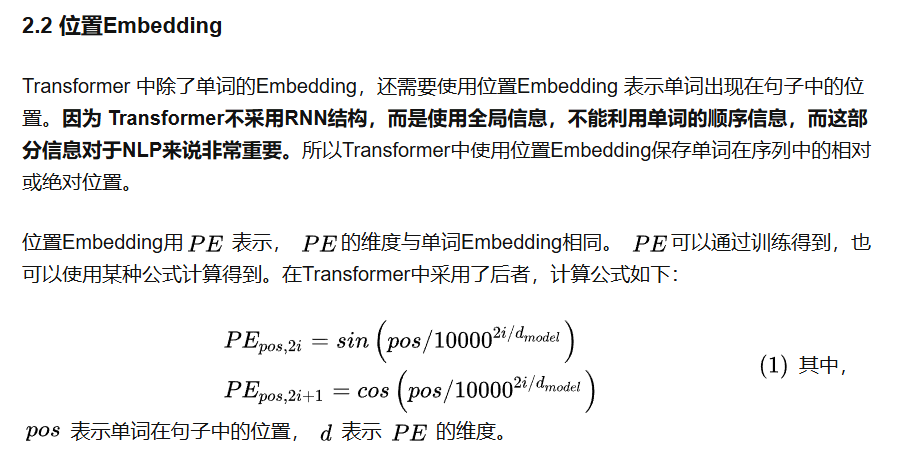

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_seq_length):
        super(PositionalEncoding,self).__init__()
        pe=torch.zeros(max_seq_length,d_model)
        position=torch.arange(0,max_seq_length,dtype=torch.float).unsqueeze(1)
        #.unsqueeze(1) 在第 1 维增加一个维度，将形状从 (max_seq_length,) 变为 (max_seq_length, 1)。
        #例如，[0, 1, 2, ...] 变为 [[0], [1], [2], ...]。
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        #这里在计算除数项
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数位置使用正弦函数
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数位置使用余弦函数
        self.register_buffer('pe', pe.unsqueeze(0))  # 注册为缓冲区
        '''缓冲区是固定的张量，不会更新，适合存储像位置编码这样不需要训练的常量。
        注册 pe 为缓冲区的优点：
        它会随模型一起保存和加载（例如通过 torch.save 和 torch.load）。
        它会自动移动到与模型相同的设备（CPU/GPU），无需手动管理。
        它不参与梯度计算，节省计算资源。'''

    def forward(self,x):
        return x+self.pe[:,:x.size(1)]

### 构建编码器模块，encoder layer

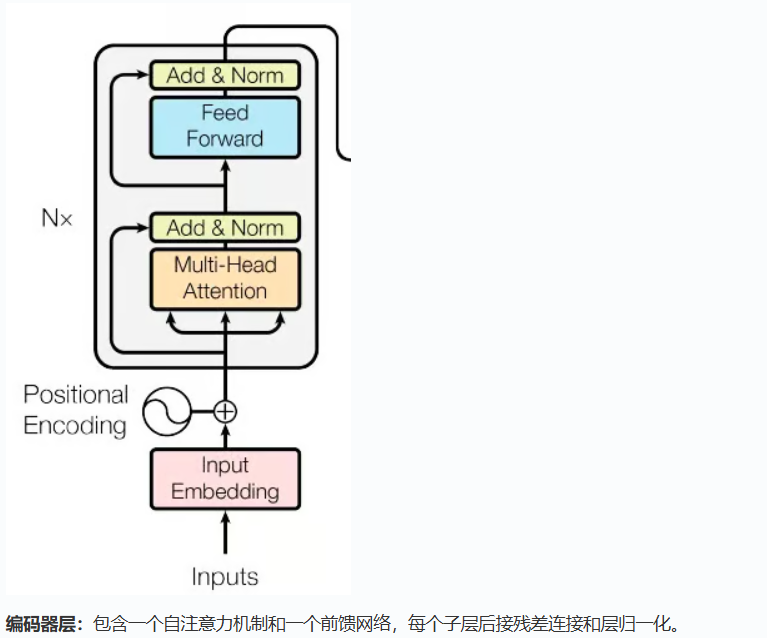
下面代码编写的是这一部分
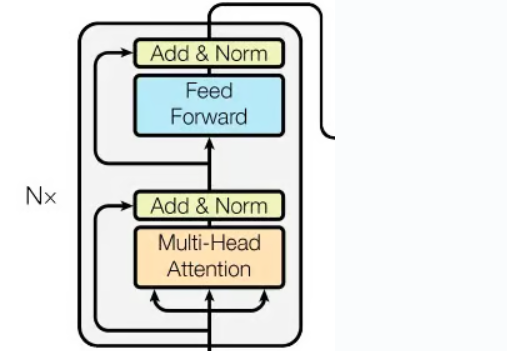

In [4]:
#这个只是一个单层，编码器由多个encoder layer堆叠而成
class EncoderLayer(nn.Module):
    def __init__(self,d_model,num_heads,d_ff,dropout):
        super(EncoderLayer,self).__init__()
        self.self_attn=MultiHeadAttention(d_model,num_heads)
        self.feed_forward=PositionWiseFeedForward(d_model,d_ff)
        self.norm1=nn.LayerNorm(d_model)
        self.norm2=nn.LayerNorm(d_model)
        self.dropout=nn.Dropout(dropout)

    def forward(self,x,mask):
        attn_output=self.self_attn(x,x,x,mask)
        x=self.norm1(x+self.dropout(attn_output))

        ff_output=self.feed_forward(x)
        x=self.norm2(x+self.dropout(ff_output))
        return x

### 构建解码器模块

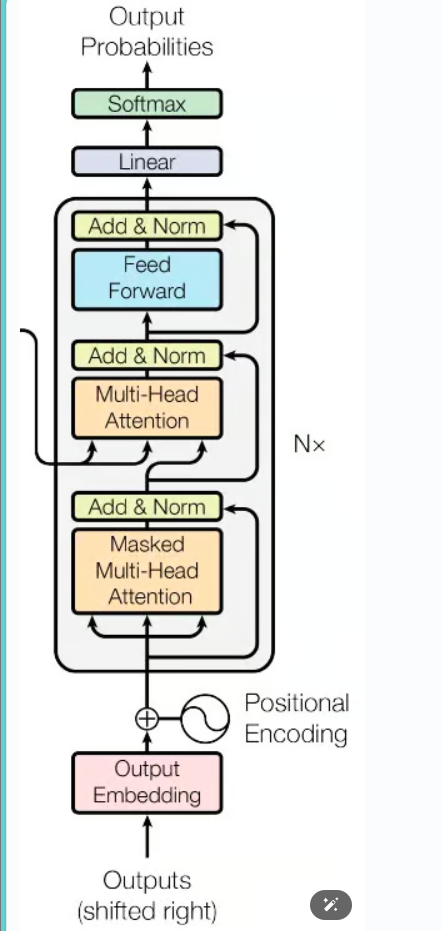

In [5]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)  # 自注意力机制
        self.cross_attn = MultiHeadAttention(d_model, num_heads)  # 交叉注意力机制
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)  # 前馈网络
        self.norm1 = nn.LayerNorm(d_model)  # 层归一化
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)  # Dropout
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        # 自注意力机制
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))  # 残差连接和层归一化
        
        # 交叉注意力机制
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))  # 残差连接和层归一化
        
        # 前馈网络
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))  # 残差连接和层归一化
        return x

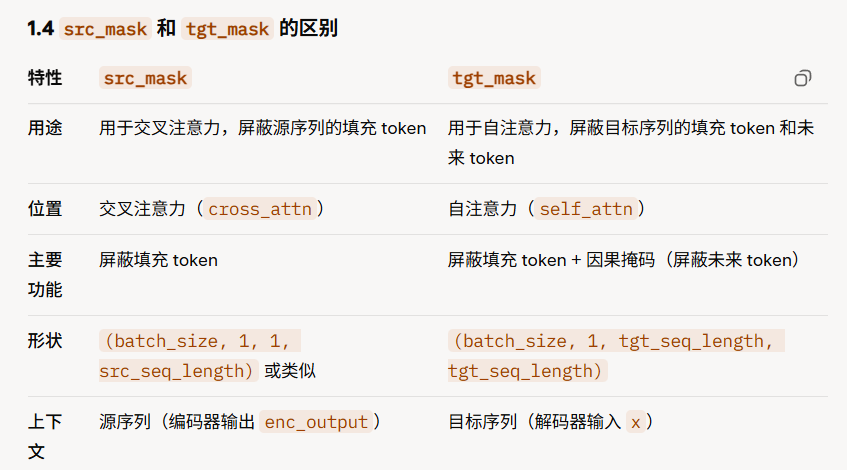
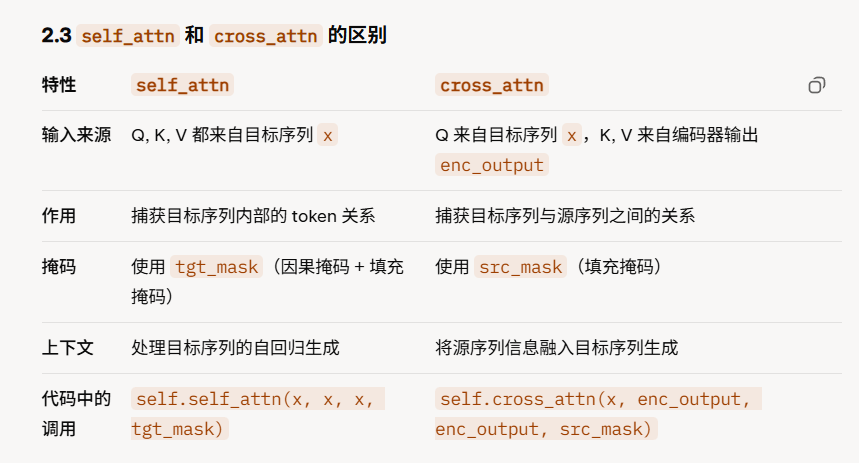

### 构建完整的transformer模型

In [6]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)  # 编码器词嵌入
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)  # 解码器词嵌入
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)  # 位置编码

        # 编码器和解码器层
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)  # 最终的全连接层
        self.dropout = nn.Dropout(dropout)  # Dropout

    def generate_mask(self, src, tgt):
        # 源掩码：屏蔽填充符（假设填充符索引为0）
        # 形状：(batch_size, 1, 1, seq_length)
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
    
        # 目标掩码：屏蔽填充符和未来信息
        # 形状：(batch_size, 1, seq_length, 1)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        # 生成上三角矩阵掩码，防止解码时看到未来信息
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask  # 合并填充掩码和未来信息掩码
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        # 生成掩码
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        
        # 编码器部分
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
        
        # 解码器部分
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
        
        # 最终输出
        output = self.fc(dec_output)
        return output

In [10]:
# 超参数
src_vocab_size = 5000  # 源词汇表大小
tgt_vocab_size = 5000  # 目标词汇表大小
d_model = 512  # 模型维度
num_heads = 8  # 注意力头数量
num_layers = 6  # 编码器和解码器层数
d_ff = 2048  # 前馈网络内层维度
max_seq_length = 100  # 最大序列长度
dropout = 0.1  # Dropout 概率

# 初始化模型
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# 生成随机数据
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # 源序列
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # 目标序列

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 忽略填充部分的损失
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# 训练循环
transformer.train()
for epoch in range(100):
    optimizer.zero_grad()  # 清空梯度，防止累积
    
    # 输入目标序列时去掉最后一个词（用于预测下一个词）
    output = transformer(src_data, tgt_data[:, :-1])  
    
    # 计算损失时，目标序列从第二个词开始（即预测下一个词）
    # output形状: (batch_size, seq_length-1, tgt_vocab_size)
    # 目标形状: (batch_size, seq_length-1)
    loss = criterion(
        output.contiguous().view(-1, tgt_vocab_size), 
        tgt_data[:, 1:].contiguous().view(-1)
    )
    
    loss.backward()        # 反向传播
    optimizer.step()       # 更新参数
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

NameError: name 'PositionalEncoding' is not defined

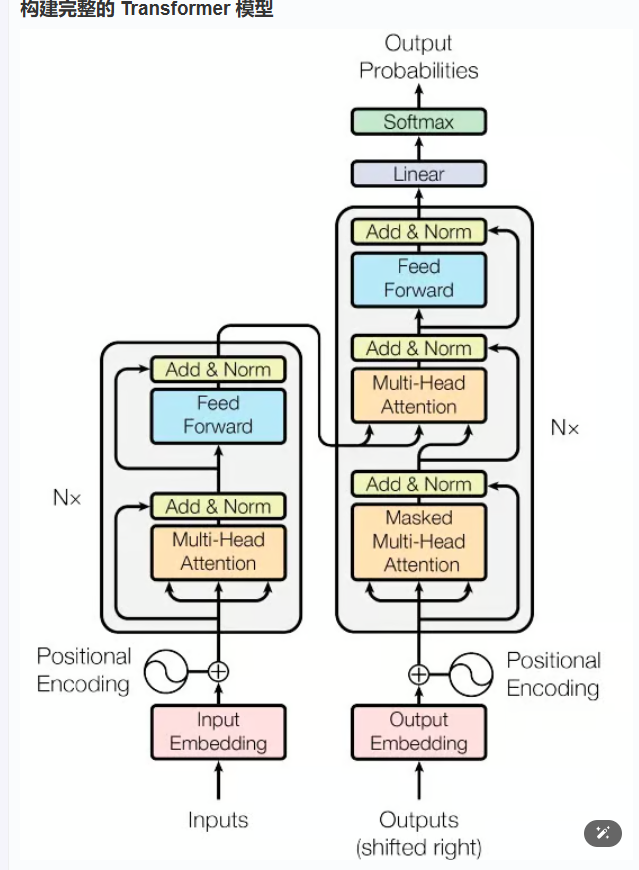